In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 30 05:43:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists
 53048_CTEH_summary_2021_04_18.pdf   fw9.pdf
 53048_CTEH_summary_2021_04_19.pdf  'Gil Idan Weekend.gsheet'
 53048_CTEH_summary_2021_04_20.pdf   headshot.jpg
 53048_CTEH_summary_2021_04_21.pdf   Identifications
 7Gz6Fx1jRQS%hqNgj7Ibjg.jpg	     LicensePlate
 Addresses.gsheet		     MedicalBills
 arcDataset			     music-matcher.mov
 basketball_images		    'Music Recommender.gslides'
 basketball-videos		    'My Drive'
 CFB.gsheet			    'Resume Editing Process.gdoc'
 Chicago			     Resume.gdoc
'Chicago Docs'			     RPI
'Colab Notebooks'		     Rupi_2
'Copy of List of Contacts.gsheet'   'Ryan Werth Resume.docx'
 demo.mov			    'Ryan Werth Resume.docx.gdoc'
'Emilys Trip.gmap'		    'Ryan Werth RESUME.gdoc'
 Fantasy.gsheet			    'San Francisco Itinerary.gdoc'
 final-presentation.mp4		    'Security Deposit 2021.gsheet'
 final-presentation-RyanWerth.mov    SouthAfrica
 Finances.gsheet		    'Untitled document.gdoc'
'Flu Analysis Pre

In [ ]:
!pip install GPUtil
!sudo apt install tesseract-ocr
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import shutil
import pickle
import math

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy

import PIL.Image
import PIL.ImageOps

from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
root_path = "/content/gdrive/MyDrive/LicensePlate"
image_path = '/data/images'
annotation_path = '/data/annotations'
imageFileNames = os.listdir(root_path+image_path)
annotationFileNames = os.listdir(root_path+annotation_path)

## Create DF of Image and annotation paths

In [ ]:
labels_dict = dict(annotation_path=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in annotationFileNames:
    annot_path = root_path+annotation_path+'/'+filename
    info = xet.parse(annot_path)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['annotation_path'].append(annot_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,annotation_path,xmin,xmax,ymin,ymax
0,/content/gdrive/MyDrive/LicensePlate/data/anno...,313,405,286,311
1,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,132,160,197
2,/content/gdrive/MyDrive/LicensePlate/data/anno...,149,272,166,193
3,/content/gdrive/MyDrive/LicensePlate/data/anno...,283,306,159,168
4,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,308,67,185


In [ ]:
# Function to get image file path

filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join(root_path+image_path,filename_image)
    return filepath_image
getFilename(filename)

'/content/gdrive/MyDrive/LicensePlate/data/images/Cars18.png'

Add image path to DF

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/gdrive/MyDrive/LicensePlate/data/images/Cars18.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars179.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars177.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars174.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars176.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars175.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars171.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars173.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars172.png',
 '/content/gdrive/MyDrive/LicensePlate/data/images/Cars170.png']

In [ ]:
df["image_path"] = image_path
df.head()

,annotation_path,xmin,xmax,ymin,ymax,image_path
0,/content/gdrive/MyDrive/LicensePlate/data/anno...,313,405,286,311,/content/gdrive/MyDrive/LicensePlate/data/imag...
1,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,132,160,197,/content/gdrive/MyDrive/LicensePlate/data/imag...
2,/content/gdrive/MyDrive/LicensePlate/data/anno...,149,272,166,193,/content/gdrive/MyDrive/LicensePlate/data/imag...
3,/content/gdrive/MyDrive/LicensePlate/data/anno...,283,306,159,168,/content/gdrive/MyDrive/LicensePlate/data/imag...
4,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,308,67,185,/content/gdrive/MyDrive/LicensePlate/data/imag...


Test Bounding Box on first row

In [ ]:
row = df.iloc[0]


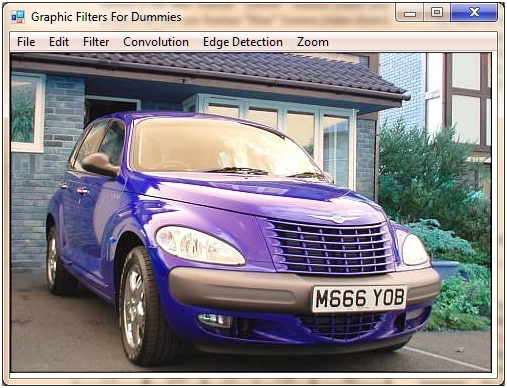

In [ ]:
file_path = row["image_path"] #path of our first image
xmin = row["xmin"]
xmax = row["xmax"]
ymin = row["ymin"]
ymax = row["ymax"]

img = cv2.imread(file_path) #read the image
# img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title=f'{file_path} with bounding box')
fig.add_shape(type='rect',x0=xmin, x1=xmax, y0=ymin, y1=ymax, xref='x', yref='y',line_color='cyan')

This is a very important step, in this process we will take each and every image and convert it into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning model.

In [ ]:

labels = df.iloc[:,1:5].values
images = df.iloc[:,5:].values
data = []
output = []
for ind in range(len(images)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

Pickle The Data For Later

In [ ]:
processed_path = '/processed_data/'

In [ ]:
pickle_out = open(root_path+processed_path+"resized_images.pickle", "wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open(root_path+processed_path+"resized_bounding_boxes.pickle", "wb")
pickle.dump(output, pickle_out)
pickle_out.close()

UnPickle

In [ ]:
pickle_in = open(root_path+processed_path+"resized_images.pickle", "rb")
data = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
pickle_in = open(root_path+processed_path+"resized_bounding_boxes.pickle", "rb")
output = pickle.load(pickle_in)
pickle_in.close()

Train/Test Split

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

Add Center, width, height of bbox for YOLO

In [ ]:
def parsing(path):
    parser = xet.parse(path).getroot()

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return width, height

In [ ]:
df[['width','height']] = df['annotation_path'].apply(parsing).apply(pd.Series)
df.head()

,annotation_path,xmin,xmax,ymin,ymax,image_path,width,height
0,/content/gdrive/MyDrive/LicensePlate/data/anno...,313,405,286,311,/content/gdrive/MyDrive/LicensePlate/data/imag...,507,388
1,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,132,160,197,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,267
2,/content/gdrive/MyDrive/LicensePlate/data/anno...,149,272,166,193,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,238
3,/content/gdrive/MyDrive/LicensePlate/data/anno...,283,306,159,168,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,225
4,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,308,67,185,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,250


In [ ]:
# Normalized center and width
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,annotation_path,xmin,xmax,ymin,ymax,image_path,width,height,center_x,center_y,bb_width,bb_height
0,/content/gdrive/MyDrive/LicensePlate/data/anno...,313,405,286,311,/content/gdrive/MyDrive/LicensePlate/data/imag...,507,388,0.708087,0.769330,0.18146,0.064433
1,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,132,160,197,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,267,0.255000,0.668539,0.15000,0.138577
2,/content/gdrive/MyDrive/LicensePlate/data/anno...,149,272,166,193,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,238,0.526250,0.754202,0.30750,0.113445
3,/content/gdrive/MyDrive/LicensePlate/data/anno...,283,306,159,168,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,225,0.736250,0.726667,0.05750,0.040000
4,/content/gdrive/MyDrive/LicensePlate/data/anno...,72,308,67,185,/content/gdrive/MyDrive/LicensePlate/data/imag...,400,250,0.475000,0.504000,0.59000,0.472000


YOLO V7

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14906, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 14906 (delta 11), reused 12 (delta 2), pack-reused 14880
Receiving objects: 100% (14906/14906), 13.93 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (10249/10249), done.


In [ ]:
!pip install -r ./yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 184 kB 15.3 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 1.6 MB 75.5 MB/s 


In [ ]:
mkdir /content/yolov5/data_images/

In [ ]:
mkdir /content/yolov5/data_images/test/

In [ ]:
mkdir /content/yolov5/data_images/train/

In [ ]:
df_train = df.iloc[:345]
df_test = df.iloc[345:]

In [ ]:
train_folder = '/content/yolov5/data_images/train'

values = df_train[['image_path','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In [ ]:
test_folder = '/content/yolov5/data_images/test'

values = df_test[['image_path','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

### Add data.yaml file to Yolo folder


```
train: data_images/train
val: data_images/test
nc: 1. 
names: [
    'license_plate'
]
```




Training

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache() 

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  6% |  1% |


In [ ]:
!python ./yolov5/train.py --data ./yolov5/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

In [ ]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-53-g65071da Python-3.8.16 torch-1.13.0+cu116 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.13.0+cu116...
TorchScript: export success ✅ 2.2s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)
requirements: YOLOv5 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages t

In [ ]:
copy('./yolov5/runs/train/Model/weights/best.pt','./gdrive/MyDrive/LicensePlate/weights/best.pt')

'./gdrive/MyDrive/LicensePlate/weights/best.pt'

In [ ]:
copy('./yolov5/runs/train/Model/weights/best.onnx','./gdrive/MyDrive/LicensePlate/weights/best.onnx')

'./gdrive/MyDrive/LicensePlate/weights/best.onnx'

# Special Code to load and rotate image

In [ ]:
def exif_transpose(img):
    if not img:
        return img

    exif_orientation_tag = 274

    # Check for EXIF data (only present on some files)
    if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
        exif_data = img._getexif()
        orientation = exif_data[exif_orientation_tag]

        # Handle EXIF Orientation
        if orientation == 1:
            # Normal image - nothing to do!
            pass
        elif orientation == 2:
            # Mirrored left to right
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            # Rotated 180 degrees
            img = img.rotate(180)
        elif orientation == 4:
            # Mirrored top to bottom
            img = img.rotate(180).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            # Mirrored along top-left diagonal
            img = img.rotate(-90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            # Rotated 90 degrees
            img = img.rotate(-90, expand=True)
        elif orientation == 7:
            # Mirrored along top-right diagonal
            img = img.rotate(90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            # Rotated 270 degrees
            img = img.rotate(90, expand=True)

    return img


In [92]:
def load_image_file(file, mode='RGB'):
    # Load the image with PIL
    img = PIL.Image.open(file)

    print("original size: ", img.size)

    if hasattr(PIL.ImageOps, 'exif_transpose'):
        # Very recent versions of PIL can do exit transpose internally
        img = PIL.ImageOps.exif_transpose(img)
    else:
        # Otherwise, do the exif transpose ourselves
        img = exif_transpose(img)

    width, height = img.size

    if width > 1000 or height > 1000:
      if width > height:
        new_size = (1000,math.floor((height/width)*1000))
      else:
        new_size = (math.floor((width/height)*1000),1000)
    
      img = img.resize(new_size)
      print("new size: ", img.size)

    img = img.convert(mode)

    return np.array(img)

In [93]:
img = load_image_file(root_path+'/validation_images/RileighTest.jpeg')
img.shape

original size:  (4032, 3024)
new size:  (750, 1000)


(1000, 750, 3)


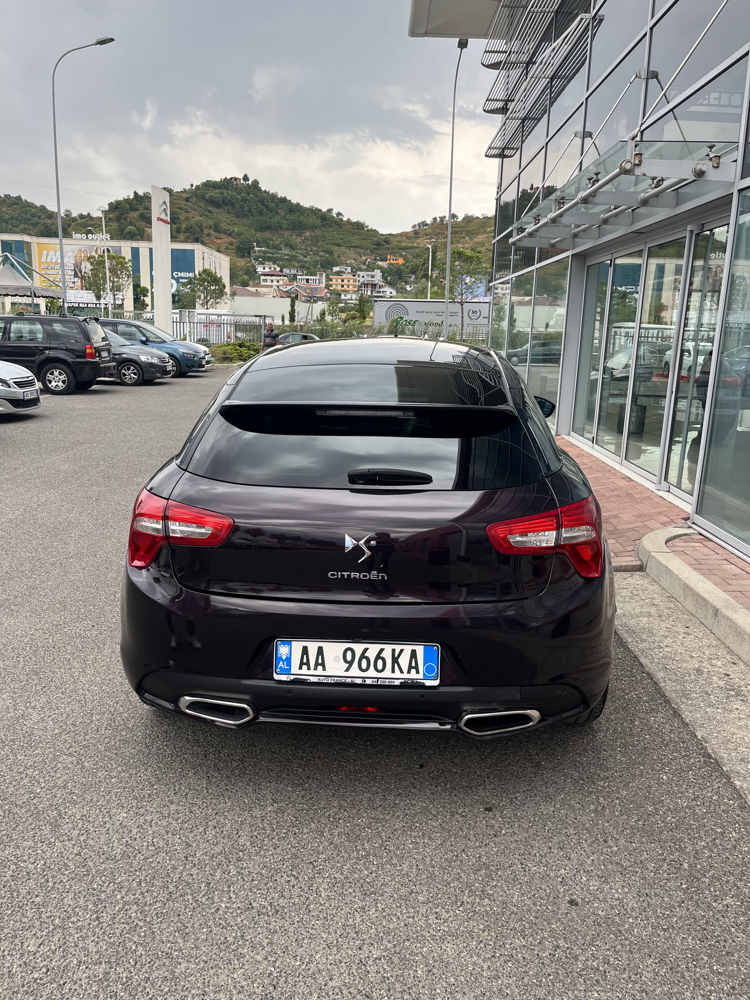

In [94]:
# LOAD THE IMAGE
fig = px.imshow(img)
fig.update_layout(width=750, height=1000, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

Predictions

In [60]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [66]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

In [67]:
def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

In [68]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-40),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+40),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    return image

In [69]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [65]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX(root_path+'/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [100]:
# test
# img = io.imread(root_path+'/validation_images/RileighTest.jpeg')
img = load_image_file(root_path+'/validation_images/TEST3.jpeg')
results = yolo_predictions(img,net)

original size:  (450, 417)



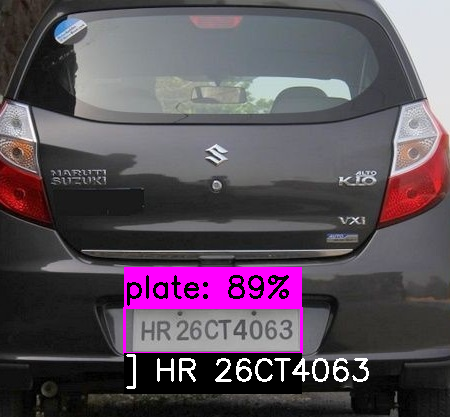

In [101]:
fig = px.imshow(img)
fig.update_layout(width=417, height=450, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()